In [7]:
import tables as tb
import glob
import invisible_cities.io.dst_io as dstio
import matplotlib.pyplot as plt
import numpy             as np
import scipy             as sci
from collections import defaultdict
import icaro.core.pmaps_monitor_functions as monFun
from functools import partial
from invisible_cities.icaro.hst_functions    import shift_to_bin_centers
from mpl_toolkits.axes_grid1 import make_axes_locatable
import invisible_cities.io.table_io as tbiof
import pandas as pd
import invisible_cities.icaro.hst_functions as histFun

In [8]:
%matplotlib inline

In [9]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

In [13]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/diffusion/bb0_GS_mode1_S1L1f.next.h5")

In [8]:
testfile = tb.open_file(inputfiles[0])

In [9]:
testfile.root.Run.extents[88][2]

20547

In [10]:
testfile.root.Run.hits[0:250][0][3]

0.011675967

In [10]:
class EventDST(tb.IsDescription):

    X        = tb.Float64Col(pos=0)
    Y        = tb.Float64Col(pos=1)
    Z        = tb.Float64Col(pos=2)
    TrueX        = tb.Float64Col(pos=0)
    TrueY        = tb.Float64Col(pos=1)
    TrueZ        = tb.Float64Col(pos=2)

In [11]:
h5out = tb.open_file('/Users/ansimez/Documents/InvCit/hdf5/diffusion/diffused_track.h5', 'w')
dst_table = tbiof.make_table(h5out, 
                            group = 'Track',
                            name = "DiffTrack",
                            fformat = EventDST,
                            description = 'Diffusion tracks',
                            compression = "ZLIB4")

Event, z, e, dr = 0, 413.73026922987674, 2.454928, 309.59184860389206


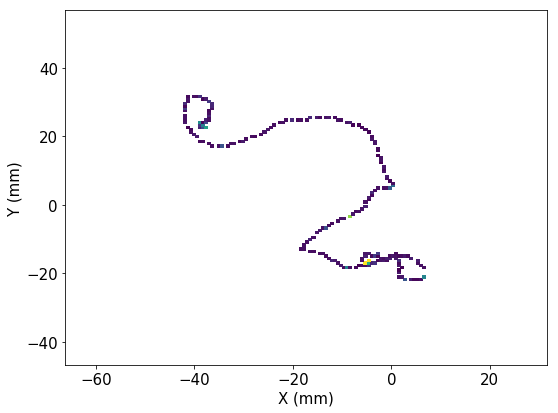

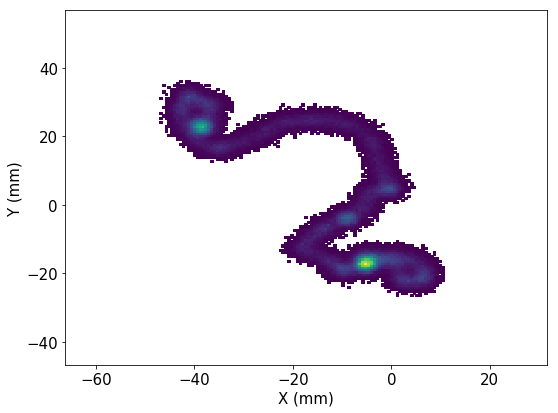

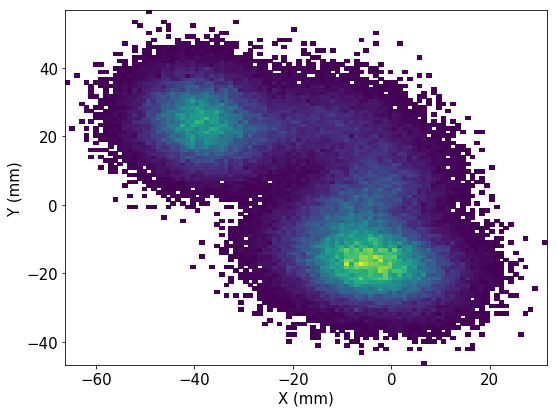

In [24]:
nsipm = 100
n_row = 4
nrows = nsipm//n_row
if nsipm%n_row>0:
    nrows +=1
fig0, axes0 = plt.subplots(1, 1, figsize=(8, 6))
fig1, axes1 = plt.subplots(1, 1, figsize=(8, 6))
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 6))

long_diff = 0.3
trans_diff2 = 0.2
trans_diff = 1.
Wi = 22.4

#row = dst_table.row
event = 88
with tb.open_file(inputfiles[0]) as h5in:
    n_init = h5in.root.Run.extents[event-1][2]+1
    for i, evt_info in enumerate(h5in.root.Run.extents[event:event+1]):
        hits = h5in.root.Run.hits[n_init:evt_info[2]+1]
        n_init = evt_info[2]+1
        x = []
        y = []
        z = []

        x2 = []
        y2 = []
        z2 = []
        
        x_hit = []
        y_hit = []
        z_hit = []
        
#        x_hit_file = []
#        y_hit_file = []
#        z_hit_file = []
        r=0
        for hc, hit in enumerate(hits):
            pos = hit[1]
            pos2 = hit[1]
            if hc > 0:
                pos2 = hits[hc-1][1]
            
            rvect = np.array(pos) - np.array(pos2)
            r += np.sqrt(np.sum(c*c for c in rvect))
            
            x.extend(np.random.normal(pos[0], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            y.extend(np.random.normal(pos[1], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            z.extend(np.random.normal(pos[2],  long_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            
            x2.extend(np.random.normal(pos[0], trans_diff2*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            y2.extend(np.random.normal(pos[1], trans_diff2*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            z2.extend(np.random.normal(pos[2],  long_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))

            x_hit.extend([pos[0]]*int(hit[3]*1000000/Wi))
            y_hit.extend([pos[1]]*int(hit[3]*1000000/Wi))
            z_hit.extend([pos[2]]*int(hit[3]*1000000/Wi))
            
        print("Event, z, e, dr = {0}, {1}, {2}, {3}".format(i, np.mean(z), len(z)*22.4/1000000, r))

        Z, xedges, yedges = np.histogram2d(x_hit, y_hit, 80)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes0.pcolormesh(shift_to_bin_centers(xedges), shift_to_bin_centers(yedges), Z)#, cmap='Blues_r')
        axes0.set_xlabel("X (mm)")
        axes0.set_ylabel("Y (mm)")        

        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig0.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)        

        Z, xedges, yedges = np.histogram2d(x2, y2, 100)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes1.pcolormesh(xedges, yedges, Z)#, cmap='Blues_r')
        axes1.set_xlabel("X (mm)")
        axes1.set_ylabel("Y (mm)")

        divider = make_axes_locatable(axes[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig1.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)
       

        Z, xedges, yedges = np.histogram2d(x, y, 100)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes2.pcolormesh(xedges, yedges, Z)#, cmap='Blues_r')
        axes2.set_xlabel("X (mm)")
        axes2.set_ylabel("Y (mm)")

        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig2.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)    
    
        axes0.set_xlim(axes2.get_xlim())
        axes1.set_xlim(axes2.get_xlim())
        axes2.set_xlim(axes2.get_xlim())
        axes0.set_ylim(axes2.get_ylim())
        axes1.set_ylim(axes2.get_ylim())
        axes2.set_ylim(axes2.get_ylim())
        fig0.tight_layout()
        fig1.tight_layout()
        fig2.tight_layout()

        
#        extent = axes0.get_tightbbox(fig0.canvas.get_renderer()).transformed(fig0.dpi_scale_trans.inverted())
        fig0.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/True_Track.png', dpi = 300, bbox_inches=extent)        
#        extent = axes1.get_tightbbox(fig1.canvas.get_renderer()).transformed(fig1.dpi_scale_trans.inverted())
        fig1.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/DiffXeHe_Track.png', dpi = 300, bbox_inches=extent) 
#        extent = axes2.get_tightbbox(fig2.canvas.get_renderer()).transformed(fig2.dpi_scale_trans.inverted())
        fig2.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/DiffXe_Track.png', dpi = 300, bbox_inches=extent)     

    
    
#    for index, xi in enumerate(x):
#        row['X'] = xi
#        row['Y'] = y[index]
#        row['Z'] = z[index]
#        row['TrueX'] = x_hit[index]
#        row['TrueY'] = y_hit[index]
#        row['TrueZ'] = z_hit[index]
#        row.append()
#    np.savetxt('/Users/ansimez/Documents/InvCit/hdf5/diffusion/diffTrack_L{0}_T{1}.txt'.format(long_diff, trans_diff), np.c_[x, y, z, x_hit, y_hit, z_hit], delimiter='\t')
    
h5out.close()

Event, z, e, dr = 0, 413.7353127228839, 2.454928, 309.59184860389206


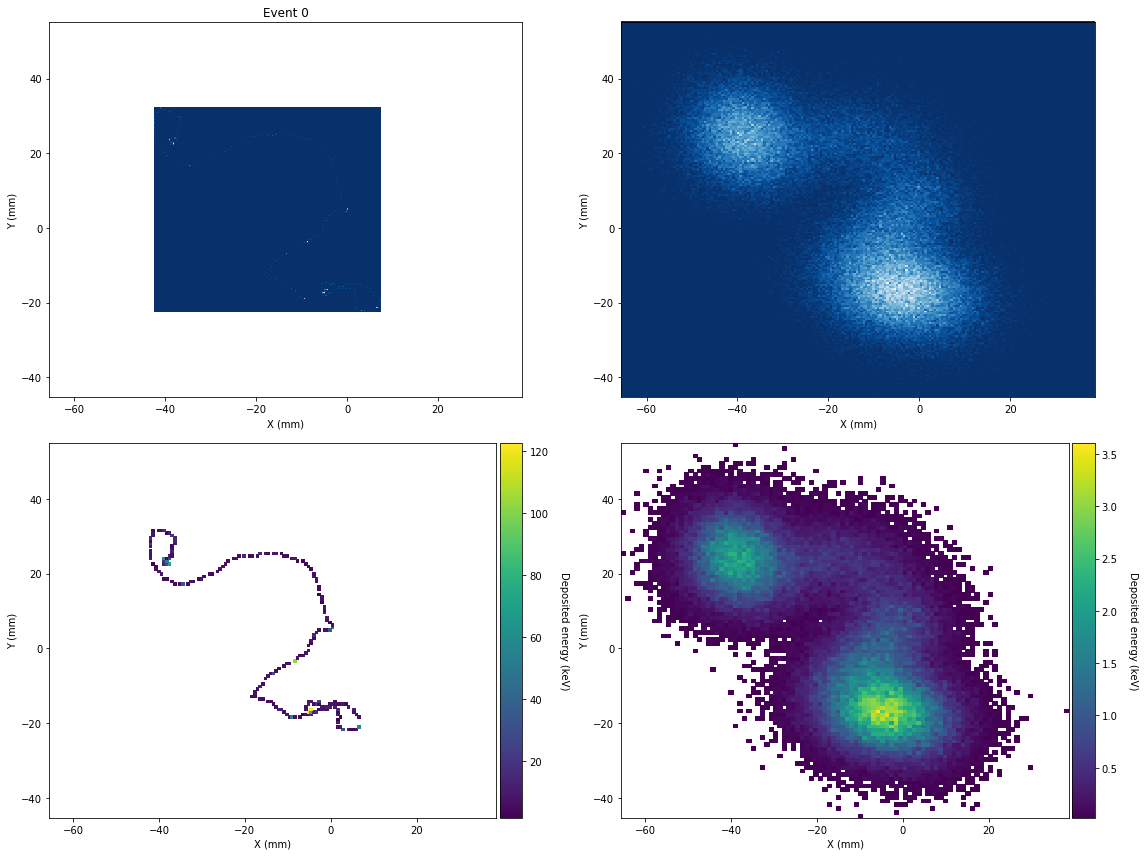

In [15]:
nsipm = 100
n_row = 4
nrows = nsipm//n_row
if nsipm%n_row>0:
    nrows +=1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

long_diff = 0.3
trans_diff = 1.
Wi = 22.4

#row = dst_table.row
event = 88
with tb.open_file(inputfiles[0]) as h5in:
    n_init = h5in.root.Run.extents[event-1][2]+1
    for i, evt_info in enumerate(h5in.root.Run.extents[event:event+1]):
        hits = h5in.root.Run.hits[n_init:evt_info[2]+1]
        n_init = evt_info[2]+1
        x = []
        y = []
        z = []
        
        x_hit = []
        y_hit = []
        z_hit = []
        
#        x_hit_file = []
#        y_hit_file = []
#        z_hit_file = []
        r=0
        for hc, hit in enumerate(hits):
            pos = hit[1]
            pos2 = hit[1]
            if hc > 0:
                pos2 = hits[hc-1][1]
            
            rvect = np.array(pos) - np.array(pos2)
            r += np.sqrt(np.sum(c*c for c in rvect))
            
            x.extend(np.random.normal(pos[0], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            y.extend(np.random.normal(pos[1], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            z.extend(np.random.normal(pos[2],  long_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))

            x_hit.extend([pos[0]]*int(hit[3]*1000000/Wi))
            y_hit.extend([pos[1]]*int(hit[3]*1000000/Wi))
            z_hit.extend([pos[2]]*int(hit[3]*1000000/Wi))
            

        print("Event, z, e, dr = {0}, {1}, {2}, {3}".format(i, np.mean(z), len(z)*22.4/1000000, r))

        Z, xedges, yedges = np.histogram2d(x_hit, y_hit, 80)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes[1][0].pcolormesh(shift_to_bin_centers(xedges), shift_to_bin_centers(yedges), Z)#, cmap='Blues_r')
        axes[1][0].set_xlabel("X (mm)")
        axes[1][0].set_ylabel("Y (mm)")        

        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)        
        
        axes[0][1].hist2d(x, y, 200, cmap='Blues_r')
        axes[0][1].set_xlabel("X (mm)")
        axes[0][1].set_ylabel("Y (mm)")

        Z, xedges, yedges = np.histogram2d(x, y, 100)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes[1][1].pcolormesh(xedges, yedges, Z)#, cmap='Blues_r')
        axes[1][1].set_xlabel("X (mm)")
        axes[1][1].set_ylabel("Y (mm)")

        divider = make_axes_locatable(axes[1][1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)
       

        axes[0][0].set_xlim(axes[0][1].get_xlim())
        axes[1][0].set_xlim(axes[0][1].get_xlim())
        axes[1][1].set_xlim(axes[0][1].get_xlim())
        axes[0][0].set_ylim(axes[0][1].get_ylim())
        axes[1][0].set_ylim(axes[0][1].get_ylim())
        axes[1][1].set_ylim(axes[0][1].get_ylim())
        fig.tight_layout()

        
    extent = axes[1][0].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/True_Track.pdf', bbox_inches=extent)        
    extent = axes[1][1].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/Diff_Track.pdf', bbox_inches=extent) 
    
    
#    for index, xi in enumerate(x):
#        row['X'] = xi
#        row['Y'] = y[index]
#        row['Z'] = z[index]
#        row['TrueX'] = x_hit[index]
#        row['TrueY'] = y_hit[index]
#        row['TrueZ'] = z_hit[index]
#        row.append()
#    np.savetxt('/Users/ansimez/Documents/InvCit/hdf5/diffusion/diffTrack_L{0}_T{1}.txt'.format(long_diff, trans_diff), np.c_[x, y, z, x_hit, y_hit, z_hit], delimiter='\t')
    
h5out.close()

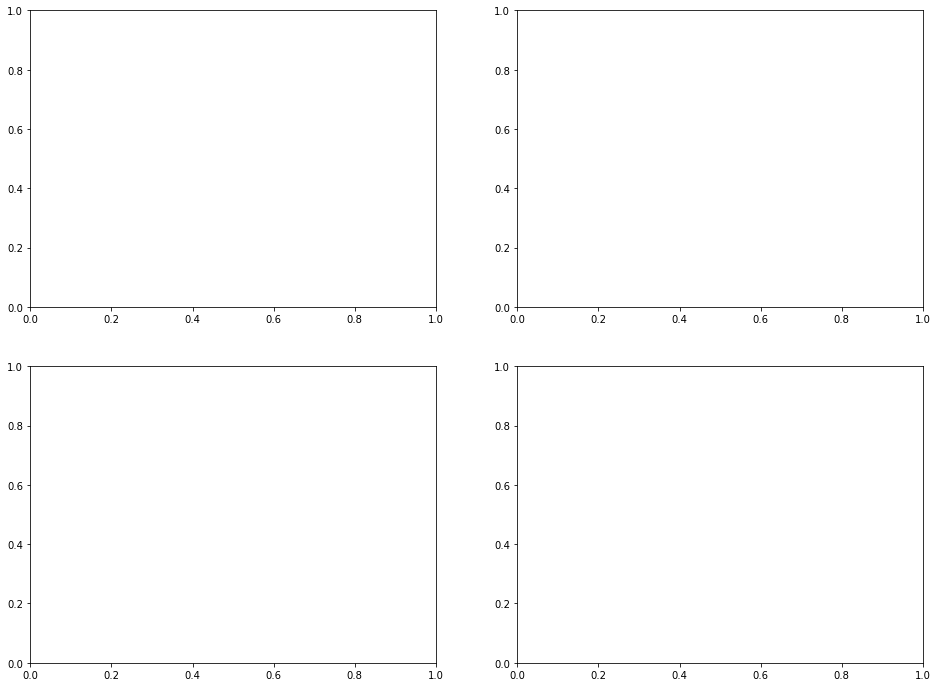

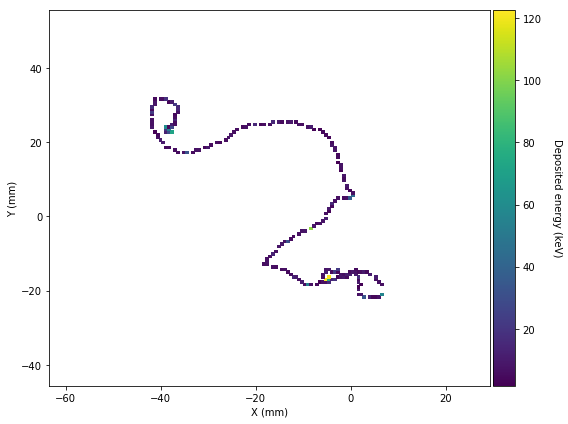

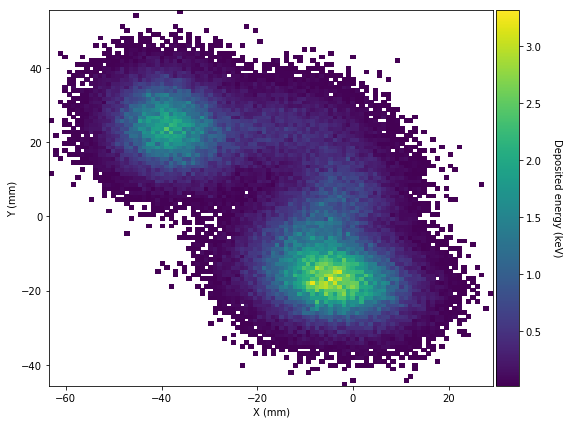

In [14]:
nsipm = 100
n_row = 4
nrows = nsipm//n_row
if nsipm%n_row>0:
    nrows +=1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

long_diff = 0.3
trans_diff = 1.
Wi = 22.4

#row = dst_table.row
event = 88
with tb.open_file(inputfiles[0]) as h5in:
    n_init = h5in.root.Run.extents[event-1][2]+1
    for i, evt_info in enumerate(h5in.root.Run.extents[event:event+1]):
        hits = h5in.root.Run.hits[n_init:evt_info[2]+1]
        n_init = evt_info[2]+1
        x = []
        y = []
        z = []
        
        x_hit = []
        y_hit = []
        z_hit = []
        
#        x_hit_file = []
#        y_hit_file = []
#        z_hit_file = []
        r=0
        for hc, hit in enumerate(hits):
            pos = hit[1]
            pos2 = hit[1]
            if hc > 0:
                pos2 = hits[hc-1][1]
            
            rvect = np.array(pos) - np.array(pos2)
            r += np.sqrt(np.sum(c*c for c in rvect))
            
            x.extend(np.random.normal(pos[0], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            y.extend(np.random.normal(pos[1], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            z.extend(np.random.normal(pos[2],  long_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))

            x_hit.extend([pos[0]]*int(hit[3]*1000000/Wi))
            y_hit.extend([pos[1]]*int(hit[3]*1000000/Wi))
            z_hit.extend([pos[2]]*int(hit[3]*1000000/Wi))

        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
            
        Z, xedges, yedges = np.histogram2d(x_hit, y_hit, 80)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes.pcolormesh(shift_to_bin_centers(xedges), shift_to_bin_centers(yedges), Z)#, cmap='Blues_r')
        axes.set_xlabel("X (mm)")
        axes.set_ylabel("Y (mm)")        

        divider = make_axes_locatable(axes)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)        
        axes.set_xlim(np.min(x), np.max(x))
        axes.set_ylim(np.min(y), np.max(y))
        fig.tight_layout()
        fig.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/True_Track.pdf')        
        
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        
        Z, xedges, yedges = np.histogram2d(x, y, 100)
        Z = np.rot90(Z)
        Z = np.flipud(Z)
        Z = np.ma.masked_where(Z<=0,Z)*Wi/1000
        z_plot = axes.pcolormesh(xedges, yedges, Z)#, cmap='Blues_r')
        axes.set_xlabel("X (mm)")
        axes.set_ylabel("Y (mm)")

        divider = make_axes_locatable(axes)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(z_plot, cax=cax, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel('Deposited energy (keV)', rotation=270)
       
        fig.tight_layout()
        fig.savefig('/Users/ansimez/Documents/InvCit/hdf5/diffusion/Diff_Track.pdf')


In [31]:
Z.sum()*22.4

2454928.0

In [19]:
np.min(z)

393.14843812349488

(array([[     0.,      0.,      0.,      0.,      0.,      0.,      0.,
           1645.,  14647.,   6856.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,
           2886.,   1433.,   2810.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,
           1672.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,
            599.,   1172.,      0.],
        [     0.,   1183.,      0.,      0.,      0.,      0.,      0.,
              0.,   1685.,      0.],
        [     0.,   1583.,   3958.,      0.,      0.,      0.,      0.,
              0.,   2353.,      0.],
        [  3842.,   1118.,      0.,   6205.,      0.,      0.,      0.,
              0.,   1747.,      0.],
        [ 12033.,   9940.,      0.,   1402.,   2373.,      0.,    311.,
           1744.,    515.,      0.],
        [  1947.,   5795.,      0.,      0.,   2198.,   3715.,   1106.,
              0.,      0.,      0.],
        [  7464.,  

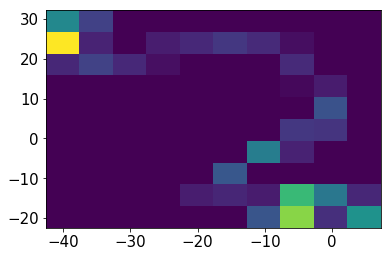

In [86]:
with tb.open_file('/Users/ansimez/Documents/InvCit/hdf5/diffusion/diffused_track.h5') as h5in:
    table = getattr(getattr(h5in.root, 'Track'), 'DiffTrack').read()
    dst = pd.DataFrame.from_records(table)

Event, z = 1, 440.57470625276676
Event, z = 2, 479.57866693294653
Event, z = 4, 392.12177506360416
Event, z = 8, 458.11003414631426
Event, z = 9, 486.40115830825954
Event, z = 12, 453.46766749596935
Event, z = 14, 472.1036460006858
Event, z = 20, 502.9932893477353
Event, z = 21, 496.28071670814006
Event, z = 23, 372.28944960026683
Event, z = 33, 403.63793091338135
Event, z = 36, 392.71690350336564
Event, z = 37, 490.28928044506625
Event, z = 39, 422.7771964009503
Event, z = 43, 469.57036176017533
Event, z = 45, 460.3881665218542
Event, z = 49, 407.0011137812352
Event, z = 52, 415.1822286599119
Event, z = 57, 513.7062876017819
Event, z = 59, 408.956139546399
Event, z = 61, 358.0422331573821
Event, z = 66, 469.707463842359
Event, z = 73, 483.0082732092135
Event, z = 74, 526.1938653543273
Event, z = 76, 402.95576803201925
Event, z = 77, 480.14705427260316
Event, z = 78, 482.6633209071436
Event, z = 80, 497.2867420911318
Event, z = 83, 503.8650145456614
Event, z = 87, 481.1549595655859
Eve

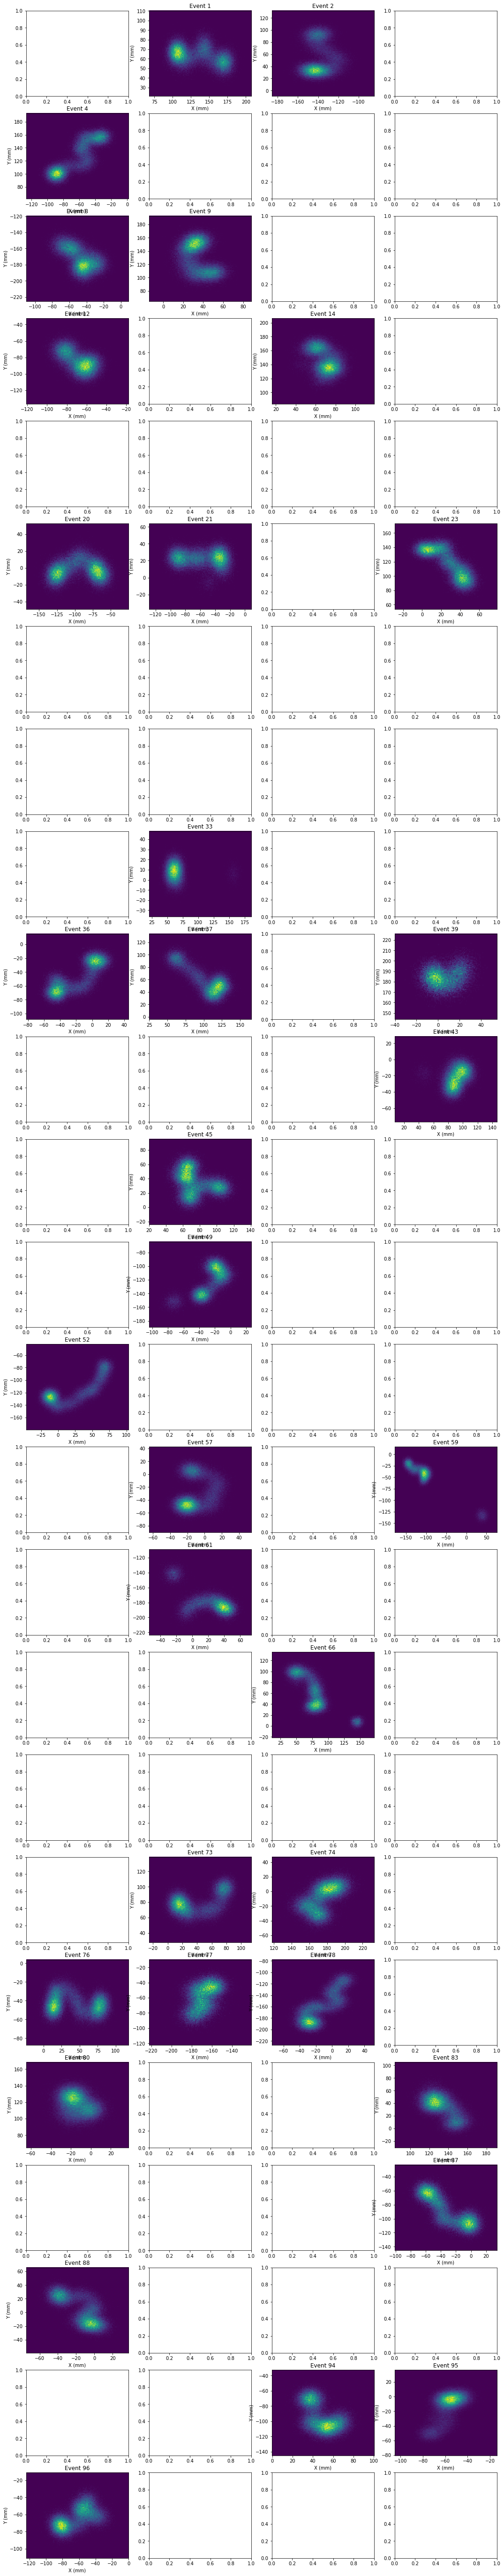

In [5]:
nsipm = 100
n_row = 4
nrows = nsipm//n_row
if nsipm%n_row>0:
    nrows +=1
fig, axes = plt.subplots(nrows, n_row, figsize=(18, 4*nrows))

long_diff = 0.3
trans_diff = 1. 
Wi = 22.4

with tb.open_file(inputfiles[0]) as h5in:
    n_init = 0#h5in.root.Run.extents[86][2]
    for i, evt_info in enumerate(h5in.root.Run.extents[:]):
        hits = h5in.root.Run.hits[n_init:evt_info[2]+1]
        n_init = evt_info[2]+1
        x = []
        y = []
        z = []
        for hit in hits:
            pos = hit[1]
            x.extend(np.random.normal(pos[0], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            y.extend(np.random.normal(pos[1], trans_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
            z.extend(np.random.normal(pos[2],  long_diff*np.sqrt(pos[2]/10.), int(hit[3]*1000000/Wi)))
        if (np.mean(z) > 350.):
            print("Event, z, e = {0}, {1}, {2}".format(i, np.mean(z), len(z)*22.4/1000000))
            
            
            axes[i//n_row][i%n_row].hist2d(x, y, [int(np.max(x)-np.min(x)+ 2*10), int(np.max(y)-np.min(y)+ 2*10)],\
                                   [[np.min(x)-10, np.max(x)+10], [np.min(y)-10, np.max(y)+10]])
            axes[i//n_row][i%n_row].set_xlabel("X (mm)")
            axes[i//n_row][i%n_row].set_ylabel("Y (mm)")
            axes[i//n_row][i%n_row].set_title("Event {}".format(i))    

In [2]:
import numpy as np

In [7]:
m = np.array([0.0027, 0.0023, 0.0022, 0.0026])
rho = 1.079
s = 14.56
conversion = 10000/1
h = m/(rho*s) * conversion

In [9]:
h.mean()

1.5594924074998218